> Autor: Fabian Massotto

---

## Objetivo
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: "focus_video.mov"

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain" y realizar tres experimentos:
    - Medición sobre todo el frame.
    - Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.
    - Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

    Para cada experimento se debe presentar :
    - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
    - Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames donde se detecta la condición de máximo enfoque.

2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

__Puntos extra__: Aplicar unsharp masking para expandir la zona de enfoque y devolver.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def image_quality_measure(image):
    # Convertimos la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Aplicamos la Transformada de Fourier
    f = np.fft.fft2(gray_image)
    
    # Shifteamos al centro
    fc = np.fft.fftshift(f)
    
    # Calculamos el valor absoluto de la transformada de Fourier centrada
    af = np.abs(fc)

    # Encontramos el valor máximo de los componentes de frecuencia
    m = np.max(af)
    
    # Calculamos el umbral y el número total de píxeles que superan el umbral
    thres = m / 1000
    th = np.sum(af > thres)

    # Paso 6: Calcular la métrica de calidad de imagen (FM)
    img_quality = th / (image.shape[0] * image.shape[1])
    
    return img_quality

#### Medición sobre todo el frame

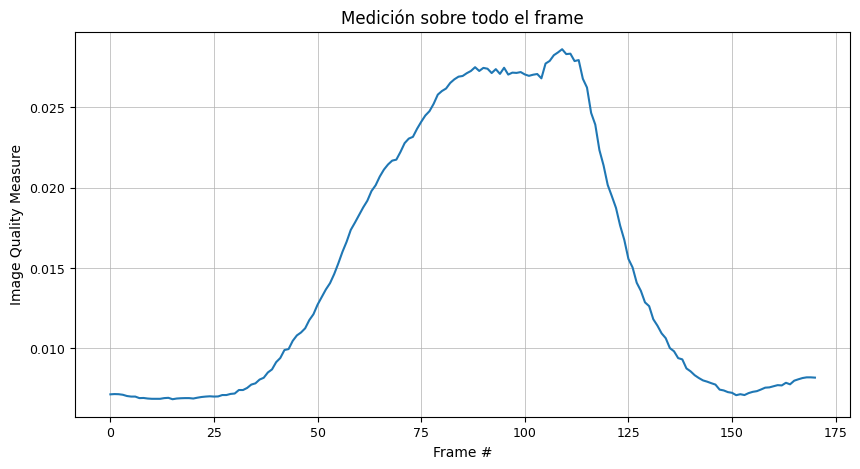

In [3]:
captura_video = cv2.VideoCapture('video/focus_video.mov')

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    best_quality = 0
    quality_by_frame = []

    # Obtenemos el frame rate del video
    fps = int(captura_video.get(cv2.CAP_PROP_FPS))
    delay = int(1000 / fps)
    
    while True:
        ret, frame = captura_video.read()
        
        # Salir si termina el video
        if not ret:
            break

        # Aplico el algoritmo
        frame_quality = image_quality_measure(frame)

        # Guardo el valor para graficarlo despues
        quality_by_frame.append(frame_quality)

        # Analizo si es mejor que el valor actual
        if frame_quality > best_quality:
            best_quality = frame_quality
        
        # Mostrar el frame
        cv2.imshow('Video', frame)
        
        # Salir del loop si se presiona la tecla 'q'
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break

# Libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
cv2.destroyAllWindows()

# Graficamos la curva del algoritmo
plt.figure(figsize=(10, 5))
plt.plot(quality_by_frame)
plt.grid(True, linewidth=0.5)
plt.xlabel('Frame #', fontsize=10)
plt.ylabel('Image Quality Measure', fontsize=10)
plt.tick_params(axis='x', labelsize=9)
plt.tick_params(axis='y', labelsize=9)
plt.title('Medición sobre todo el frame', fontsize=12)
plt.show()

#### Medición sobre una ROI

In [4]:
def get_roi(image, roi_percentage):
    # Obtenemos las dimensiones de la imagen
    h, w = image.shape[:2]  
    
    # Calculamos el área de la imagen
    area = h * w  
    
    # Calculamos el área de la ROI
    roi_area = area * (roi_percentage / 100)  
    
    # Calcular la longitud de los lados de la ROI (asumiendo un cuadrado)
    roi_size = int(np.sqrt(roi_area))
    
    # Coordenadas del centro de la imagen
    center_x, center_y = w // 2, h // 2
    
    # Coordenadas de la esquina superior izquierda de la ROI
    x_start = center_x - roi_size // 2
    y_start = center_y - roi_size // 2
    
    # Extraer la ROI
    roi = image[y_start:y_start + roi_size, x_start:x_start + roi_size]
    
    return roi, (x_start, y_start, x_start+roi_size, y_start+roi_size)

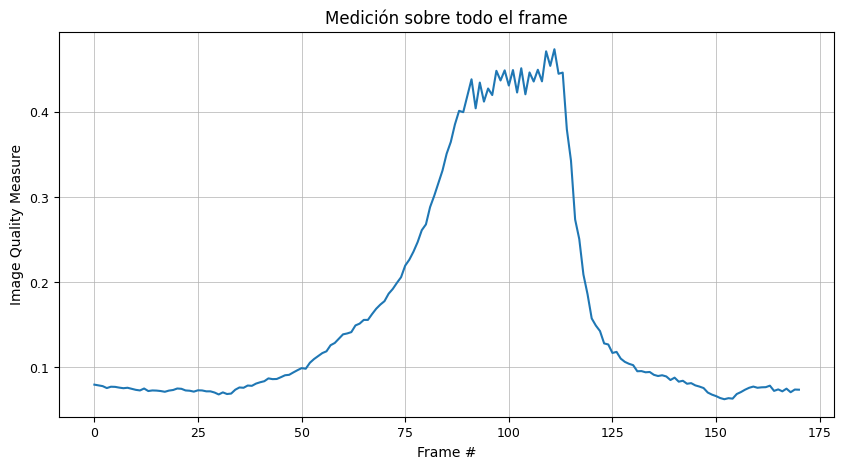

In [5]:
captura_video = cv2.VideoCapture('video/focus_video.mov')

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    best_quality = 0
    quality_by_frame = []

    # Obtenemos el frame rate del video
    fps = int(captura_video.get(cv2.CAP_PROP_FPS))
    delay = int(1000 / fps)
    
    # Hago una primera pasada para obtener el máximo enfoque
    while True:
        ret, frame = captura_video.read()
        
        # Salir si termina el video
        if not ret:
            break

        # Establecemos la ROI
        roi, coords = get_roi(frame, 5)

        # Aplico el algoritmo
        frame_quality = image_quality_measure(roi)

        # Guardo el valor para graficarlo despues
        quality_by_frame.append(frame_quality)

        # Analizo si es mejor que el valor actual
        if frame_quality > best_quality:
            best_quality = frame_quality

    # Reseteamos el video
    captura_video.set(cv2.CAP_PROP_POS_FRAMES, 0)
    frame_number = 0

    # Hago una segunda pasada para marcar en el video el momento de mejor enfoque  
    while True:
        ret, frame = captura_video.read()

        # Salir si termina el video
        if not ret:
            break
        
        # Seteo el color de la ROI en base al valor de calidad del frame
        # Considero el momento de mejor enfoque a partir de un 85% de la calidad máxima
        roi_color = (0,0,255)
        frame_quality = quality_by_frame[frame_number]
        if frame_quality >= best_quality * 0.85:
            roi_color = (0,255,0)
        
        # Dibujo la ROI
        cv2.rectangle(frame, (coords[0],coords[1]), (coords[2],coords[3]), roi_color, 2, cv2.LINE_AA)

        # Mostrar el frame
        cv2.imshow('Video', frame)

        frame_number += 1
        
        # Salir del loop si se presiona la tecla 'q'
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break

# Libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
cv2.destroyAllWindows()

# Graficamos la curva del algoritmo
plt.figure(figsize=(10, 5))
plt.plot(quality_by_frame)
plt.grid(True, linewidth=0.5)
plt.xlabel('Frame #', fontsize=10)
plt.ylabel('Image Quality Measure', fontsize=10)
plt.tick_params(axis='x', labelsize=9)
plt.tick_params(axis='y', labelsize=9)
plt.title('Medición sobre todo el frame', fontsize=12)
plt.show()

#### Medición sobre una matriz de enfoque

In [32]:
def get_matrix(image, x, y):
    # Utilizo un tamaño fijo para los bloques de la matriz. 
    #  - Cada bloque tendrá un tamaño de 10x10 px
    #  - La separación entre bloques será de 10 px
    block_px = 20
    space_px = 20

    # Obtenemos las dimensiones de la imagen
    h, w = image.shape[:2]  
    
    # Coordenadas del centro de la imagen
    center_x, center_y = w // 2, h // 2 
    
    # Calculamos los lados de la matriz
    matrix_x = x * block_px + (x-1) * space_px
    matrix_y = y * block_px + (y-1) * space_px
    
    # Coordenadas de la esquina superior izquierda de la ROI
    x_start = center_x - matrix_x // 2
    y_start = center_y - matrix_y // 2
    
    # Extraer la matriz
    matrix = []
    for i in range(y):
        row = []
        for j in range(x):
            row.append((image[y_start+i*(block_px+space_px):y_start+(i+1)*block_px+i*space_px, x_start+j*(block_px+space_px):x_start+(j+1)*block_px+j*space_px], ( x_start+j*(block_px+space_px), y_start+i*(block_px+space_px), x_start+(j+1)*block_px+j*space_px, y_start+(i+1)*block_px+i*space_px)))
        matrix.append(row)
    
    return matrix

In [43]:
def focus_matrix(x, y):
    captura_video = cv2.VideoCapture('video/focus_video.mov')

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
    else:
        best_quality = 0
        quality_by_frame = []

        # Obtenemos el frame rate del video
        fps = int(captura_video.get(cv2.CAP_PROP_FPS))
        delay = int(1000 / fps)
        
        # Hago una primera pasada para obtener el máximo enfoque
        while True:
            ret, frame = captura_video.read()
            
            # Salir si termina el video
            if not ret:
                break

            # Establecemos la matriz
            matrix = get_matrix(frame, x, y)

            # Aplico el algoritmo
            quality_list = []
            for row in matrix:
                for block in row:
                    quality_list.append(image_quality_measure(block[0]))

            # Promedio los resultados de cada bloque de la matriz
            frame_quality = np.mean(quality_list)

            # Guardo el valor para graficarlo despues
            quality_by_frame.append(frame_quality)

            # Analizo si es mejor que el valor actual
            if frame_quality > best_quality:
                best_quality = frame_quality

        # Reseteamos el video
        captura_video.set(cv2.CAP_PROP_POS_FRAMES, 0)
        frame_number = 0

        # Hago una segunda pasada para marcar en el video el momento de mejor enfoque  
        while True:
            ret, frame = captura_video.read()

            # Salir si termina el video
            if not ret:
                break

            # Seteo el color de la ROI en base al valor de calidad del frame
            # Considero el momento de mejor enfoque a partir de un 85% de la calidad máxima
            roi_color = (0,0,255)
            frame_quality = quality_by_frame[frame_number]
            if frame_quality >= best_quality * 0.85:
                roi_color = (0,255,0)
            
            # Dibujo la matriz
            for row in matrix:
                for block in row:
                    cv2.rectangle(frame, (block[1][0],block[1][1]), (block[1][2],block[1][3]), roi_color, 2, cv2.LINE_AA)

            # Mostrar el frame
            cv2.imshow('Video', frame)

            frame_number += 1
            
            # Salir del loop si se presiona la tecla 'q'
            if cv2.waitKey(delay) & 0xFF == ord('q'):
                break

    # Libera el objeto de captura de video y cierra todas las ventanas
    captura_video.release()
    cv2.destroyAllWindows()

    # Graficamos la curva del algoritmo
    plt.figure(figsize=(10, 5))
    plt.plot(quality_by_frame)
    plt.grid(True, linewidth=0.5)
    plt.xlabel('Frame #', fontsize=10)
    plt.ylabel('Image Quality Measure', fontsize=10)
    plt.tick_params(axis='x', labelsize=9)
    plt.tick_params(axis='y', labelsize=9)
    plt.title('Medición sobre todo el frame', fontsize=12)
    plt.show()

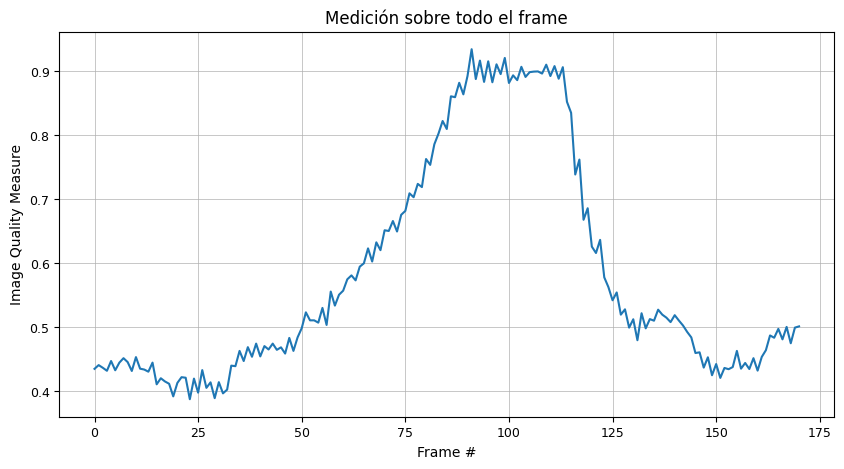

In [44]:
# Matriz de 3x3
focus_matrix(3, 3)

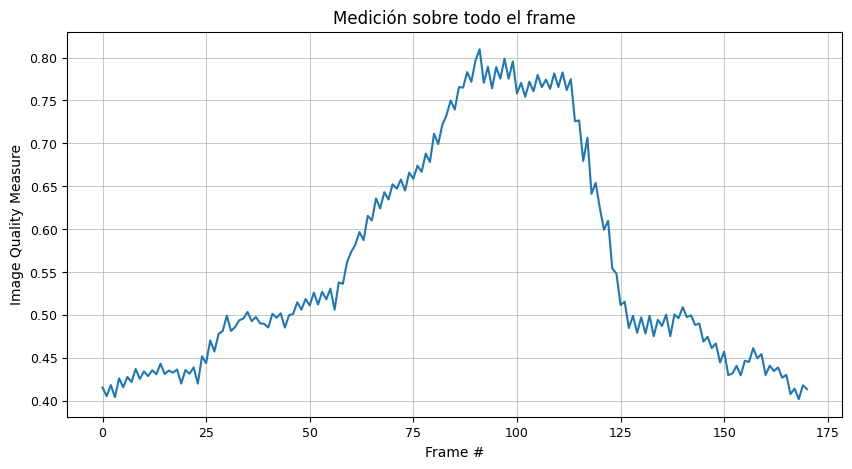

In [45]:
# Matriz de 7x5
focus_matrix(7, 5)

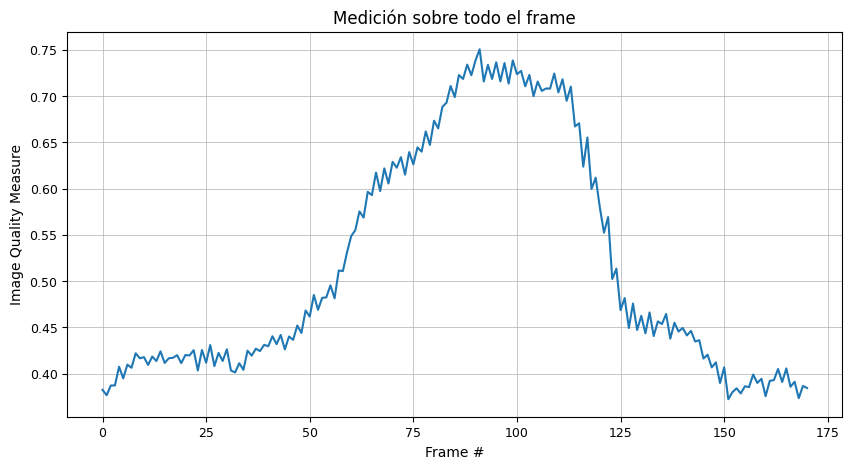

In [46]:
# Matriz de 5x7
focus_matrix(5, 7)